In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
import pywt
from scipy.ndimage import gaussian_filter1d, maximum_filter
from scipy.signal import find_peaks

from helper_funcs import *
from findpeaks import findpeaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# Get frequncy axis
f = rfftfreq(32768, 1/44100)[0:8192]

In [8]:
index = 2000
spectrum = df.iloc[index]['spectrum']

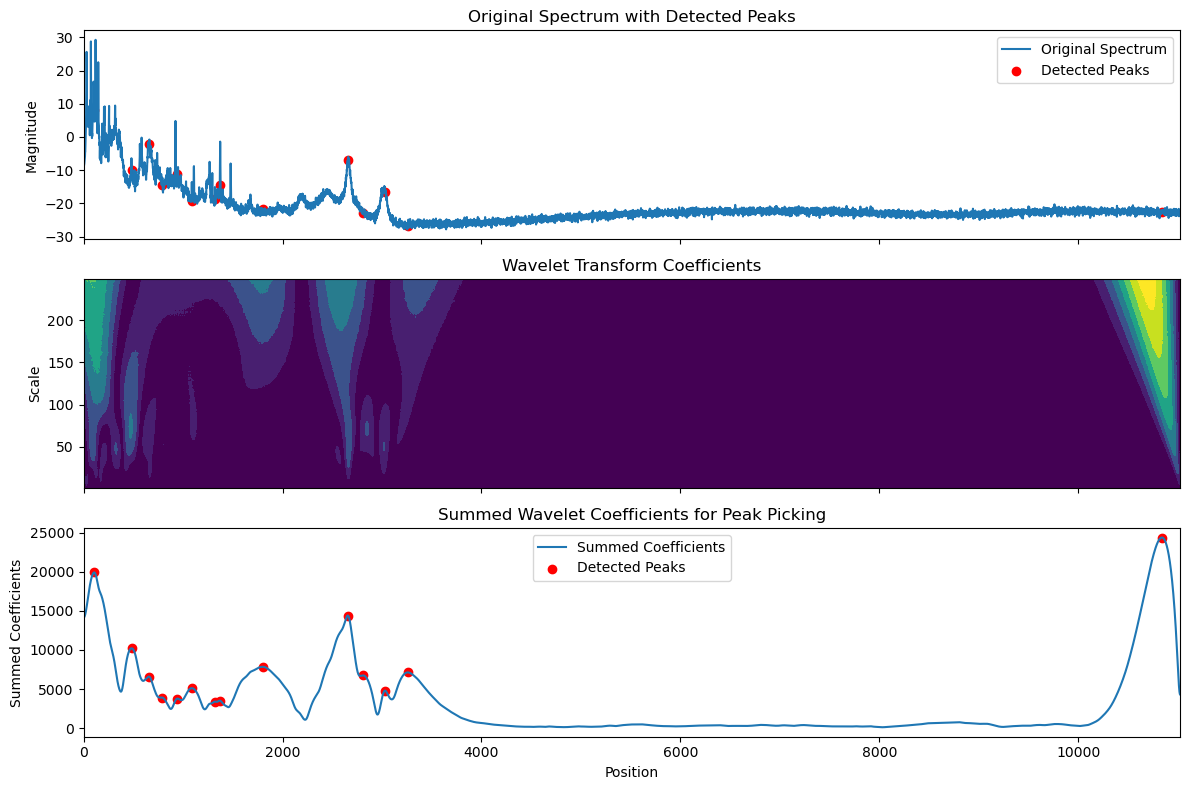

Detected peak positions: [  106.32019043   481.80541992   656.76269531   784.61608887
   943.42346191  1086.08093262  1321.6003418   1368.70422363
  1799.36828613  2655.31311035  2808.73718262  3030.79833984
  3258.24279785 10841.96777344]


In [9]:
# 1D Summed Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Sum across scales to enhance peak prominence
summed_coefficients = np.sum(coefficients, axis=0)

# Smooth the summed coefficients with gaussian filter
sigma = 10
summed_coefficients = gaussian_filter1d(summed_coefficients, sigma)

# Find peaks using scipy.signal.find_peaks
peaks, properties = find_peaks(summed_coefficients, height=1000, distance=10)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
axes[0].scatter(f[peaks], spectrum[peaks], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
axes[1].set_title("Wavelet Transform Coefficients")
axes[1].set_ylabel("Scale")
# fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")

# Summed coefficients and detected peaks
axes[2].plot(f, summed_coefficients, label="Summed Coefficients")
axes[2].scatter(f[peaks], summed_coefficients[peaks], color='red', label="Detected Peaks")
axes[2].set_title("Summed Wavelet Coefficients for Peak Picking")
axes[2].set_xlabel("Position")
axes[2].set_ylabel("Summed Coefficients")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions
print("Detected peak positions:", f[peaks])


In [10]:
# 2D persistent homology wavelet coefficient peak picking
fmax_index = 500
spectrum = spectrum[0:fmax_index]
f = f[0:fmax_index]

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 0.
[findpeaks] >Detect peaks using topology method with limit at 0.
[findpeaks] >Fin.


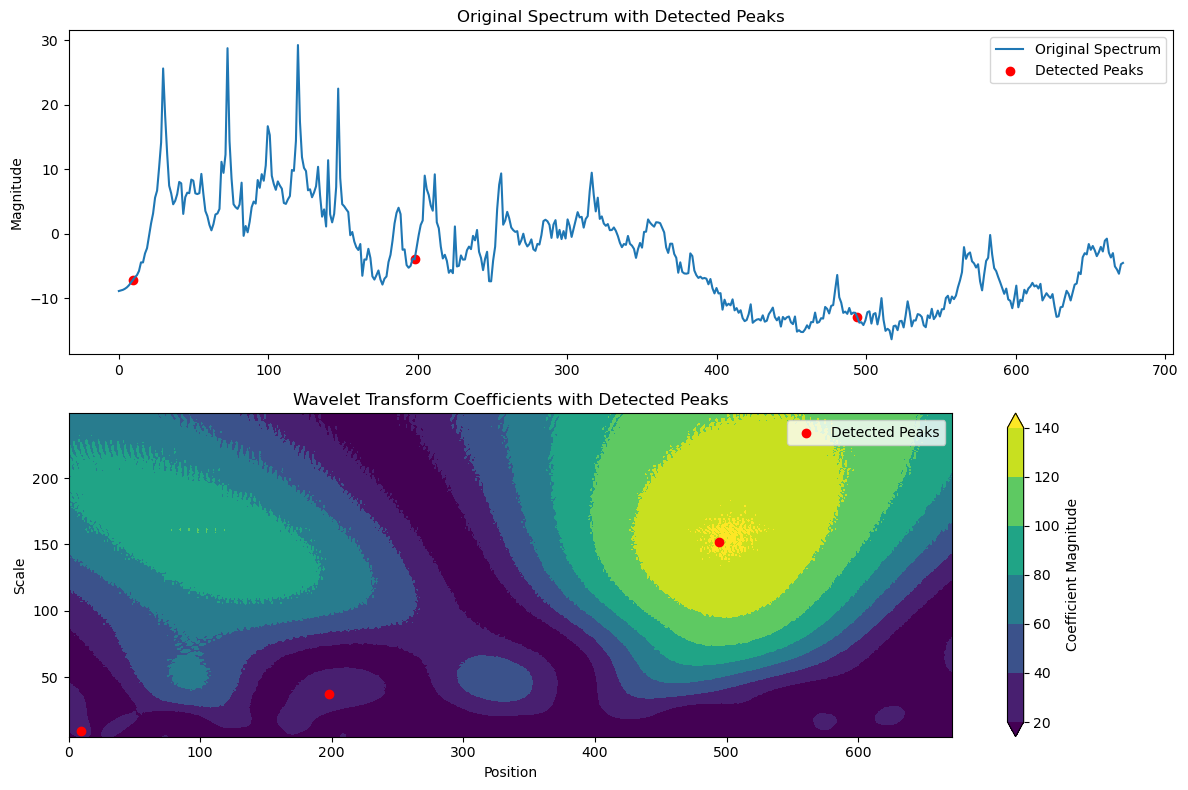

Detected peak at position: 9.42, scale: 9.00
Detected peak at position: 197.84, scale: 37.00
Detected peak at position: 493.92, scale: 152.00


In [12]:
# 2D Persistent Homology Wavelet Coefficient Peak Picking
max_persistence = 50

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(5, 250, 1)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Find peaks using the findpeaks library
fp = findpeaks(method='topology')
results = fp.fit(coefficients)

# Get peak coordinates and create a binary peak positions matrix
peaks_2d = results['Xdetect']
peak_positions_binary = (peaks_2d > max_persistence).astype(int)  # Convert non-zero values to 1, others to 0

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
if np.any(peak_positions_binary):
    peak_positions_f = f[np.where(peak_positions_binary.sum(axis=0) > 0)]
    axes[0].scatter(peak_positions_f, spectrum[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap with detected peaks
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
if np.any(peak_positions_binary):
    peak_indices = np.argwhere(peak_positions_binary == 1)
    axes[1].scatter(f[peak_indices[:, 1]], scales[peak_indices[:, 0]], color='red', label="Detected Peaks")
axes[1].set_title("Wavelet Transform Coefficients with Detected Peaks")
axes[1].set_ylabel("Scale")
axes[1].set_xlabel("Position")
fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions and scales if there are any
if np.any(peak_positions_binary):
    for scale, pos in zip(scales[peak_indices[:, 0]], f[peak_indices[:, 1]]):
        print(f"Detected peak at position: {pos:.2f}, scale: {scale:.2f}")
else:
    print("No peaks detected.")


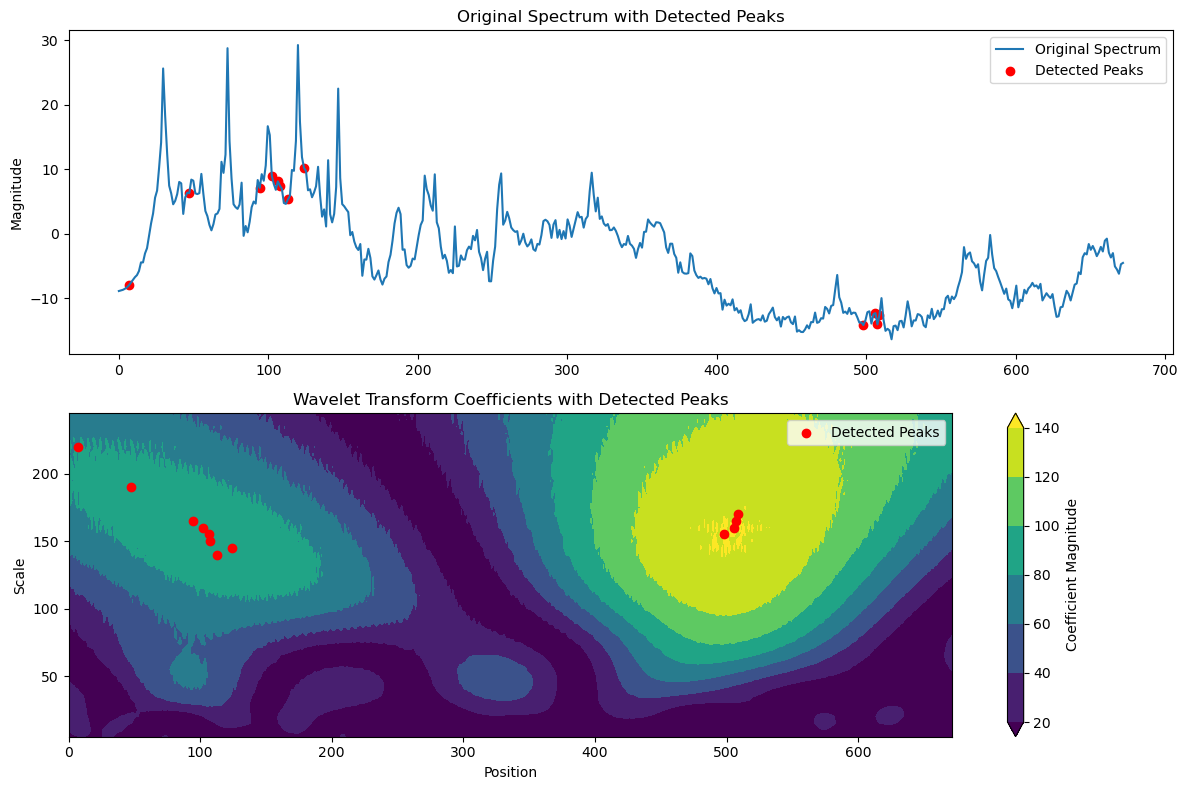

Detected peak at position: 113.05, scale: 140.00
Detected peak at position: 123.82, scale: 145.00
Detected peak at position: 107.67, scale: 150.00
Detected peak at position: 106.32, scale: 155.00
Detected peak at position: 497.96, scale: 155.00
Detected peak at position: 102.28, scale: 160.00
Detected peak at position: 506.03, scale: 160.00
Detected peak at position: 94.21, scale: 165.00
Detected peak at position: 507.38, scale: 165.00
Detected peak at position: 508.72, scale: 170.00
Detected peak at position: 47.10, scale: 190.00
Detected peak at position: 6.73, scale: 220.00


In [13]:
# 2D Persistent Homology Wavelet Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(5, 250, 5)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Find peaks in each row (along scales) and each column (along positions)
from scipy.signal import find_peaks

# Threshold for minimum peak height
min_height = -10
min_distance = 100
min_prominence = 10

# Find peaks in each row
row_peaks = [find_peaks(row, height=min_height, prominence=min_prominence, distance=min_distance)[0] for row in coefficients]

# Find peaks in each column
col_peaks = [find_peaks(coefficients[:, i], height=min_height, prominence=min_prominence, distance=min_distance)[0] for i in range(coefficients.shape[1])]

# Combine row and column peaks to find 2D peaks
peak_positions_binary = np.zeros_like(coefficients, dtype=int)
for i, peaks in enumerate(row_peaks):
    for peak in peaks:
        if i in col_peaks[peak]:
            peak_positions_binary[i, peak] = 1

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
if np.any(peak_positions_binary):
    peak_positions_f = f[np.where(peak_positions_binary.sum(axis=0) > 0)]
    axes[0].scatter(peak_positions_f, spectrum[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap with detected peaks
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
if np.any(peak_positions_binary):
    peak_indices = np.argwhere(peak_positions_binary == 1)
    axes[1].scatter(f[peak_indices[:, 1]], scales[peak_indices[:, 0]], color='red', label="Detected Peaks")
axes[1].set_title("Wavelet Transform Coefficients with Detected Peaks")
axes[1].set_ylabel("Scale")
axes[1].set_xlabel("Position")
fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions and scales if there are any
if np.any(peak_positions_binary):
    for scale, pos in zip(scales[peak_indices[:, 0]], f[peak_indices[:, 1]]):
        print(f"Detected peak at position: {pos:.2f}, scale: {scale:.2f}")
else:
    print("No peaks detected.")


In [ ]:
double_spectrum = rfft(spectrum)
cutoff = 100
double_spectrum[cutoff:] = np.zeros(len(double_spectrum[cutoff:]), dtype=complex)
filtered_spectrum = irfft(double_spectrum)
plt.plot(f, filtered_spectrum)